# 🔄 Markov Switching Regime Model - Visualizations

This notebook runs and visualizes the Markov Switching model for oil price regime detection.

**Markov Switching Features:**
- Auto-detects distinct market regimes (high/low volatility)
- Calculates transition probabilities between states
- Smoothed regime probabilities show confidence over time
- Compares with Bayesian change point detection

In [1]:
# Setup
import sys
sys.path.append('../services')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.regime_switching import markov_regression
import warnings
warnings.filterwarnings('ignore')

from db_service import load_market_data, load_detected_change_points

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["font.size"] = 11

print("✅ Setup complete!")

✅ Setup complete!


## 1️⃣ Load and Prepare Data

In [2]:
# Load data
df = load_market_data()
bayesian_cps = load_detected_change_points()

# Calculate log returns
df['log_return'] = np.log(df['price'] / df['price'].shift(1))
df = df.dropna()

print(f"📊 Dataset:")
print(f"   Shape: {df.shape}")
print(f"   Date Range: {df.index[0]} to {df.index[-1]}")
print(f"   Mean Log Return: {df['log_return'].mean():.6f}")
print(f"   Std Log Return: {df['log_return'].std():.6f}")

INFO:db_service:✅ Loaded 4615 rows from market_data.
INFO:db_service:✅ Loaded 11 detected change points.


📊 Dataset:
   Shape: (4571, 11)
   Date Range: 2007-10-01 00:00:00 to 2026-02-13 00:00:00
   Mean Log Return: -0.000036
   Std Log Return: 0.023624


## 2️⃣ Fit Markov Switching Model

In [3]:
# Fit 2-regime Markov Switching model
# Regime 0: Low volatility (normal)
# Regime 1: High volatility (crisis)

print("\n🔄 Fitting Markov Switching Model (2 regimes)...")
print("   This may take 2-5 minutes...\n")

ms_model = markov_regression.MarkovRegression(
    endog=df['log_return'],
    k_regimes=2,
    switching_variance=True
)

ms_result = ms_model.fit()

print("\n" + "="*70)
print("  MARKOV SWITCHING MODEL SUMMARY")
print("="*70)
print(ms_result.summary())
print("="*70)


🔄 Fitting Markov Switching Model (2 regimes)...
   This may take 2-5 minutes...


  MARKOV SWITCHING MODEL SUMMARY
                        Markov Switching Model Results                        
Dep. Variable:             log_return   No. Observations:                 4571
Model:               MarkovRegression   Log Likelihood               11353.892
Date:                Sat, 14 Feb 2026   AIC                         -22695.784
Time:                        15:10:54   BIC                         -22657.220
Sample:                             0   HQIC                        -22682.206
                               - 4571                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          

## 3️⃣ Regime Parameters Analysis

In [6]:
# Extract regime parameters
params = ms_result.params

# Print all parameter names to debug
print("\n📋 Available parameters:")
print(params.index.tolist())

# Extract sigma values more robustly
# Try different parameter naming conventions
try:
    # Try bracket notation first
    sigma_0 = np.sqrt(ms_result.params['sigma2[0]'])
    sigma_1 = np.sqrt(ms_result.params['sigma2[1]'])
except KeyError:
    try:
        # Try dot notation
        sigma_0 = np.sqrt(ms_result.params['sigma2.0'])
        sigma_1 = np.sqrt(ms_result.params['sigma2.1'])
    except KeyError:
        # Try direct attribute access
        sigma_0 = np.sqrt(ms_result.params.filter(like='sigma2').iloc[0])
        sigma_1 = np.sqrt(ms_result.params.filter(like='sigma2').iloc[1])

high_vol_regime = 0 if sigma_0 > sigma_1 else 1
low_vol_regime = 1 - high_vol_regime

# Convert to float for formatting
sigma_0 = float(sigma_0)
sigma_1 = float(sigma_1)

print("\n" + "="*70)
print("  REGIME PARAMETERS")
print("="*70)
print(f"\nRegime {low_vol_regime} (Low Volatility / Normal):")
print(f"   Volatility: {min(sigma_0, sigma_1):.6f}")
print(f"\nRegime {high_vol_regime} (High Volatility / Crisis):")
print(f"   Volatility: {max(sigma_0, sigma_1):.6f}")
print(f"\nVolatility Ratio (Crisis/Normal): {max(sigma_0, sigma_1) / min(sigma_0, sigma_1):.2f}x")
print("="*70)

# Transition matrix
print("\n" + "="*70)
print("  TRANSITION PROBABILITY MATRIX")
print("="*70)
print("\n   From State → To State\n")
print(ms_result.regime_transition)
print("\n" + "="*70)

# Expected duration in each regime
p00 = float(ms_result.regime_transition[0, 0])
p11 = float(ms_result.regime_transition[1, 1])
duration_0 = 1 / (1 - p00)
duration_1 = 1 / (1 - p11)

print(f"\nExpected Duration in Regime 0: {duration_0:.1f} days")
print(f"Expected Duration in Regime 1: {duration_1:.1f} days")
print("="*70)



📋 Available parameters:
['p[0->0]', 'p[1->0]', 'const[0]', 'const[1]', 'sigma2[0]', 'sigma2[1]']

  REGIME PARAMETERS

Regime 0 (Low Volatility / Normal):
   Volatility: 0.015500

Regime 1 (High Volatility / Crisis):
   Volatility: 0.042263

Volatility Ratio (Crisis/Normal): 2.73x

  TRANSITION PROBABILITY MATRIX

   From State → To State

[[[0.97868467]
  [0.0835807 ]]

 [[0.02131533]
  [0.9164193 ]]]


Expected Duration in Regime 0: 46.9 days
Expected Duration in Regime 1: 12.0 days


## 4️⃣ Smoothed Regime Probabilities

In [7]:
# Get smoothed probabilities
smoothed_probs = ms_result.smoothed_marginal_probabilities

# Determine most likely regime at each time point
df['regime'] = smoothed_probs[high_vol_regime] > 0.5
df['regime'] = df['regime'].map({True: 'Crisis', False: 'Normal'})
df['crisis_prob'] = smoothed_probs[high_vol_regime]

print(f"\n📊 Regime Distribution (Markov):")
print(df['regime'].value_counts())
print(f"\n   Normal: {(df['regime'] == 'Normal').sum() / len(df) * 100:.1f}%")
print(f"   Crisis: {(df['regime'] == 'Crisis').sum() / len(df) * 100:.1f}%")


📊 Regime Distribution (Markov):
regime
Normal    3741
Crisis     830
Name: count, dtype: int64

   Normal: 81.8%
   Crisis: 18.2%


## 5️⃣ Price Timeline with Markov Regimes

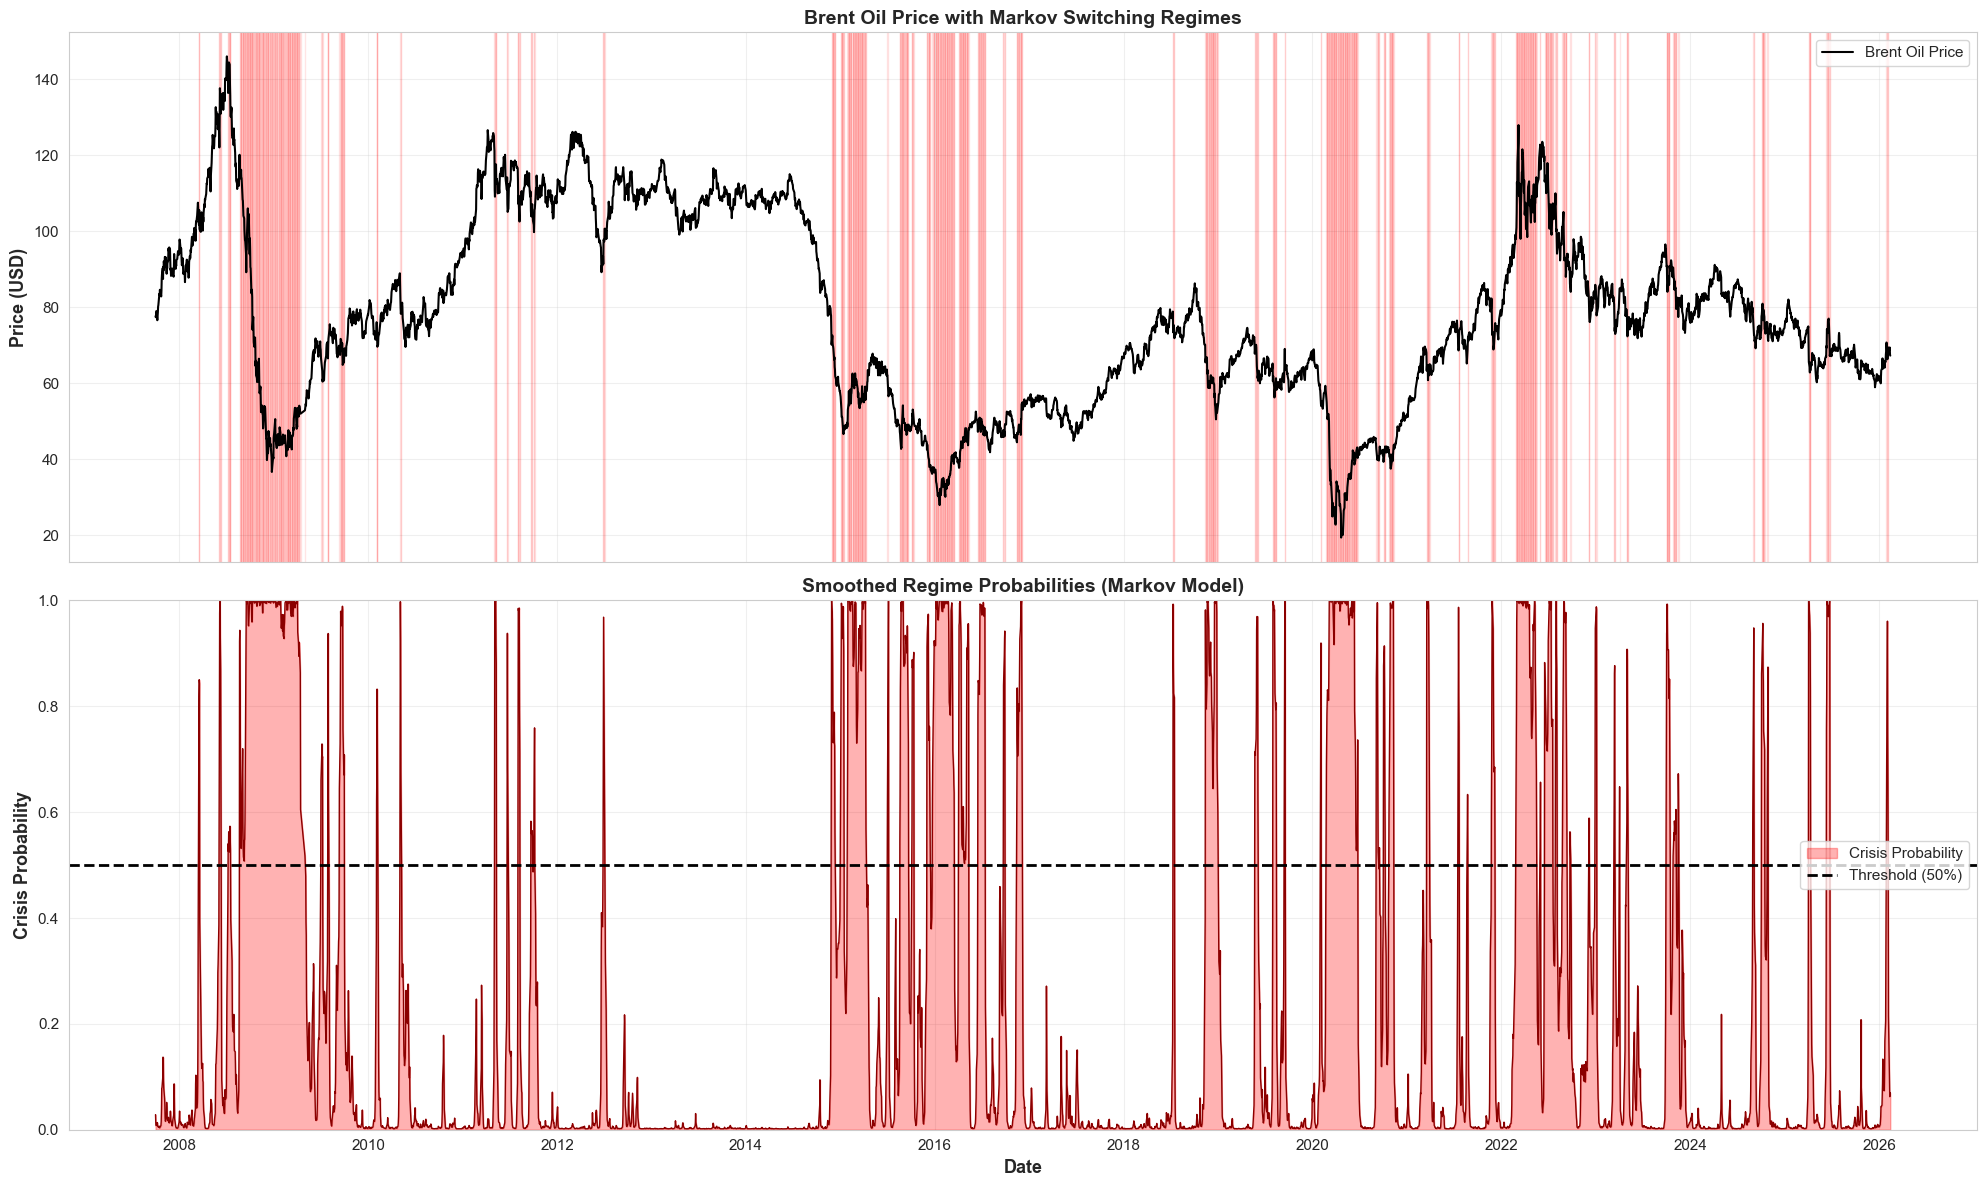

✅ Plot saved: markov_regime_timeline.png


In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# Top: Price with regime shading
ax1.plot(df.index, df['price'], color='black', linewidth=1.5, label='Brent Oil Price')

# Shade crisis periods
crisis_periods = df[df['regime'] == 'Crisis']
for date in crisis_periods.index:
    ax1.axvspan(date, date, color='red', alpha=0.1)

ax1.set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
ax1.set_title('Brent Oil Price with Markov Switching Regimes', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Crisis probability over time
ax2.fill_between(df.index, 0, df['crisis_prob'], 
                 color='red', alpha=0.3, label='Crisis Probability')
ax2.plot(df.index, df['crisis_prob'], color='darkred', linewidth=1)
ax2.axhline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold (50%)')
ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
ax2.set_ylabel('Crisis Probability', fontsize=13, fontweight='bold')
ax2.set_title('Smoothed Regime Probabilities (Markov Model)', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/markov_regime_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: markov_regime_timeline.png")

## 6️⃣ Regime Transition Diagram

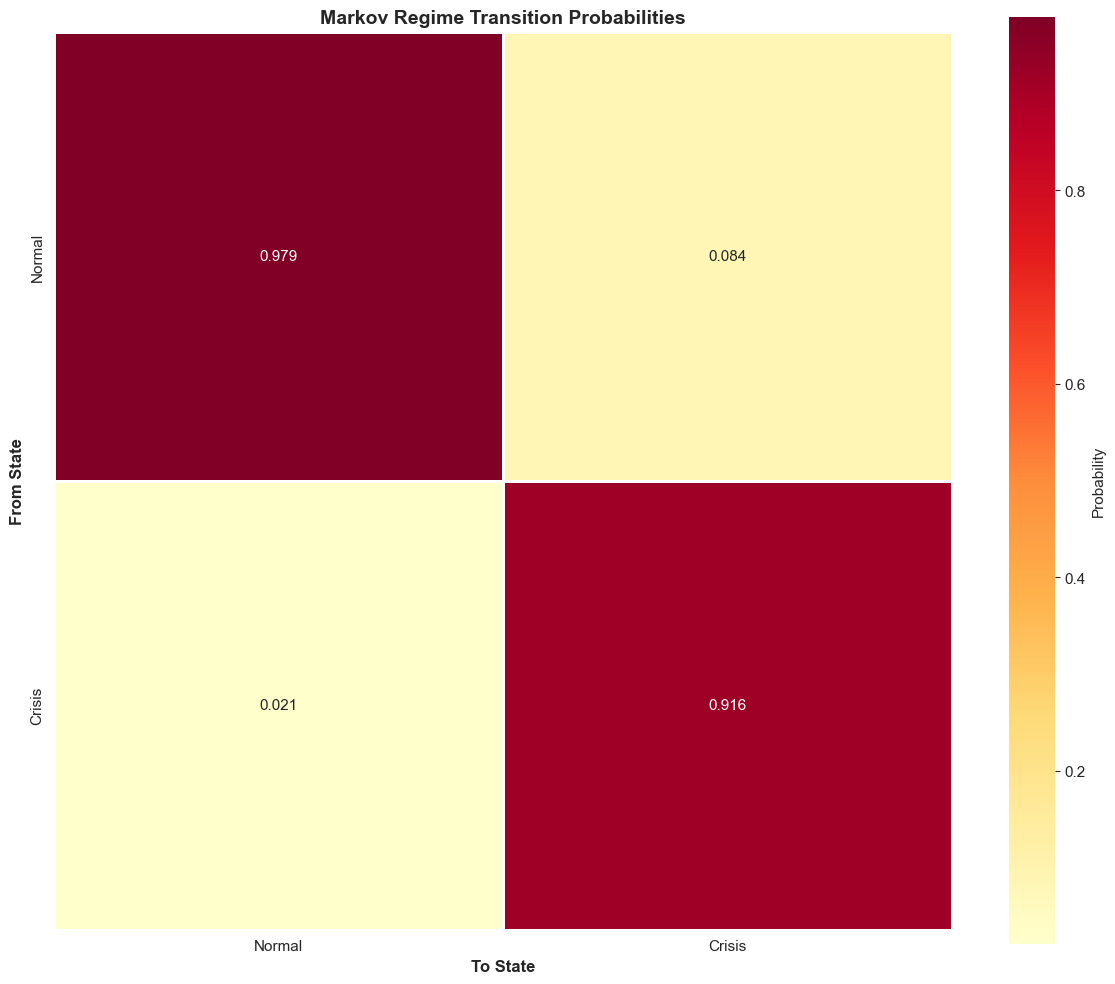

✅ Plot saved: markov_transition_matrix.png


In [12]:
# Visualize transition probabilities
fig, ax = plt.subplots(figsize=(12, 10))

# Create transition matrix heatmap
trans_matrix = ms_result.regime_transition
# Remove extra dimension if present
if trans_matrix.ndim == 3:
    trans_matrix = trans_matrix.squeeze()

labels = ['Normal', 'Crisis']

sns.heatmap(trans_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Probability'},
            square=True, linewidths=2, ax=ax)

ax.set_title('Markov Regime Transition Probabilities', fontsize=14, fontweight='bold')
ax.set_xlabel('To State', fontsize=12, fontweight='bold')
ax.set_ylabel('From State', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/v2outputs/markov_transition_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: markov_transition_matrix.png")

## 7️⃣ Comparison: Markov vs Bayesian Change Points

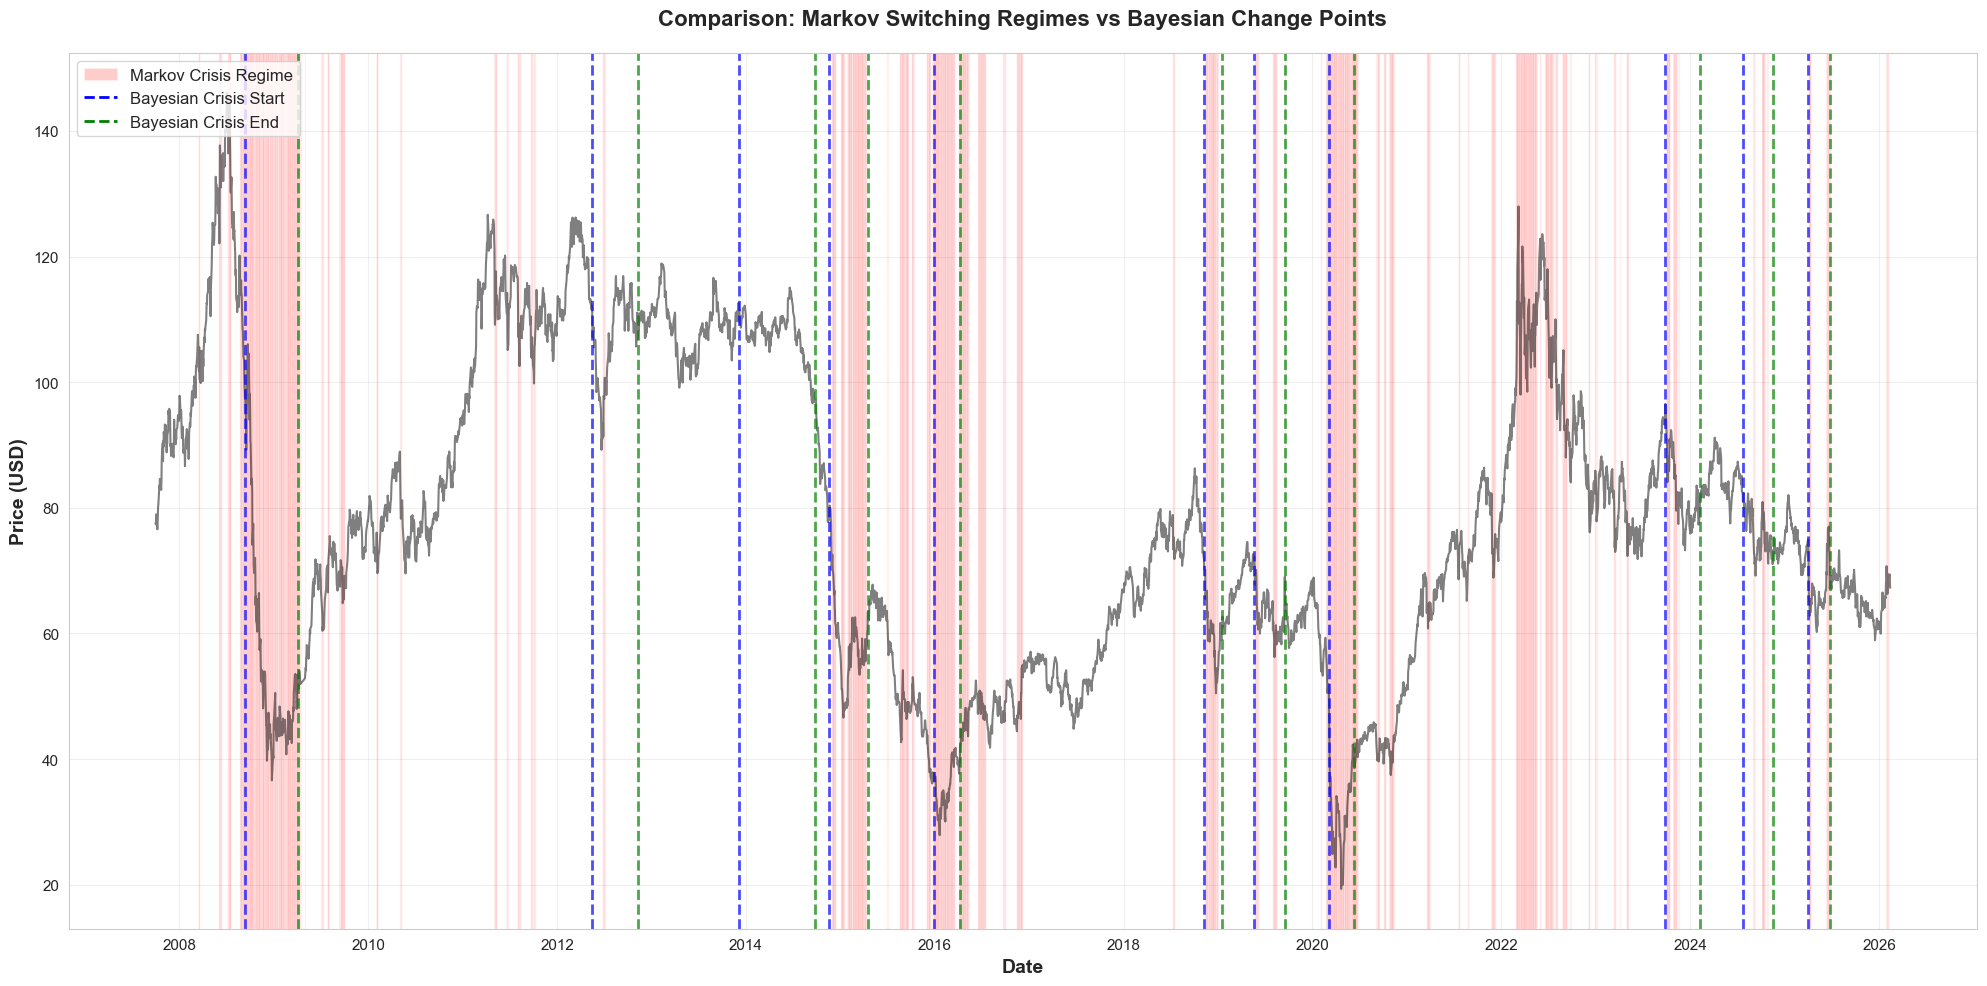

✅ Plot saved: markov_vs_bayesian_comparison.png


In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot price
ax.plot(df.index, df['price'], color='black', linewidth=1.5, alpha=0.5, label='Price')

# Markov regimes (background shading)
crisis_periods = df[df['regime'] == 'Crisis']
for date in crisis_periods.index:
    ax.axvspan(date, date, color='red', alpha=0.05)

# Bayesian change points (vertical lines)
for i, cp in bayesian_cps.iterrows():
    start = cp['crisis_start_date']
    end = cp['crisis_end_date']
    ax.axvline(start, color='blue', linestyle='--', linewidth=2, alpha=0.7, 
              label='Bayesian CP' if i == 0 else '')
    ax.axvline(end, color='green', linestyle='--', linewidth=2, alpha=0.7,
              label='Bayesian End' if i == 0 else '')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.2, label='Markov Crisis Regime'),
    plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=2, label='Bayesian Crisis Start'),
    plt.Line2D([0], [0], color='green', linestyle='--', linewidth=2, label='Bayesian Crisis End')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=12)

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
ax.set_title('Comparison: Markov Switching Regimes vs Bayesian Change Points', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/markov_vs_bayesian_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: markov_vs_bayesian_comparison.png")

## 8️⃣ Volatility Clustering Analysis

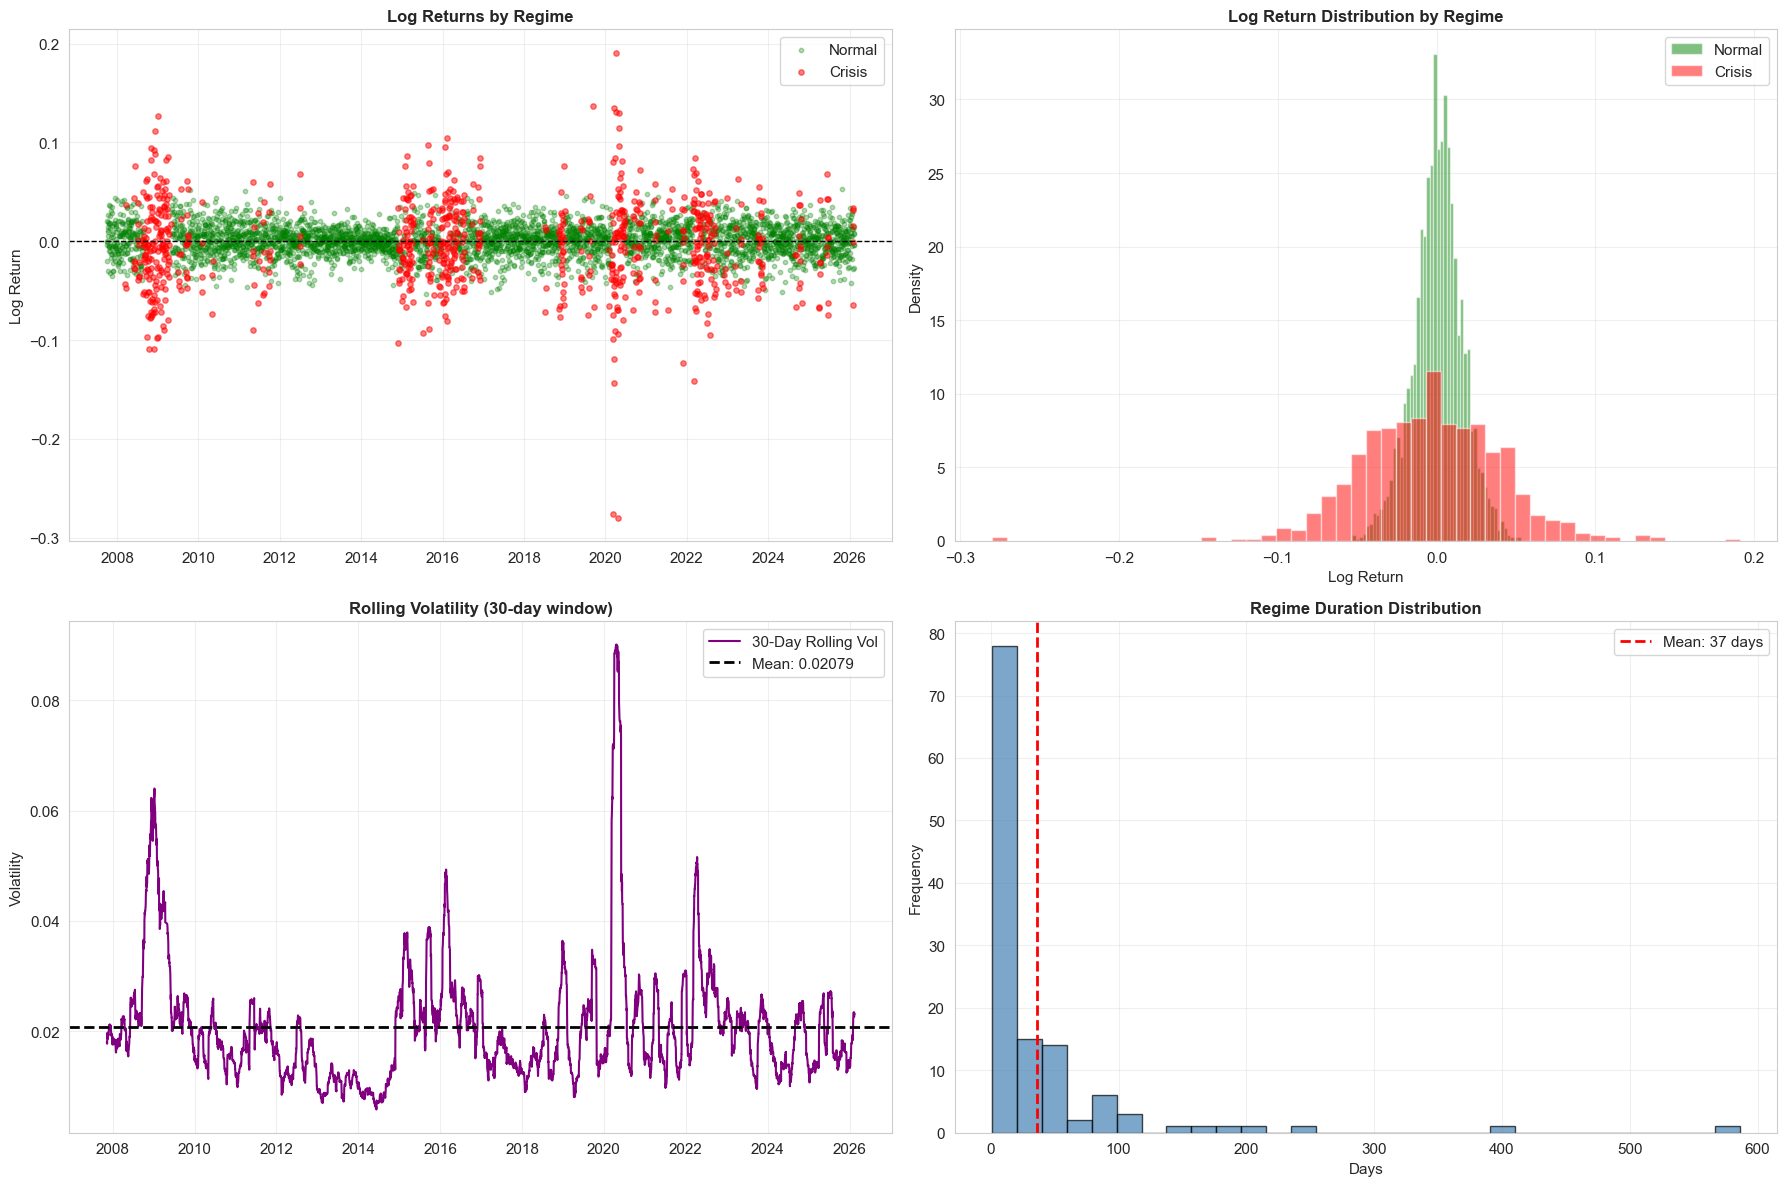

✅ Plot saved: markov_volatility_clustering.png


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Log returns colored by regime
normal_mask = df['regime'] == 'Normal'
crisis_mask = df['regime'] == 'Crisis'

axes[0, 0].scatter(df.index[normal_mask], df.loc[normal_mask, 'log_return'], 
                  c='green', alpha=0.3, s=10, label='Normal')
axes[0, 0].scatter(df.index[crisis_mask], df.loc[crisis_mask, 'log_return'], 
                  c='red', alpha=0.5, s=15, label='Crisis')
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('Log Returns by Regime', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution by regime
axes[0, 1].hist(df.loc[normal_mask, 'log_return'], bins=50, 
               alpha=0.5, color='green', label='Normal', density=True)
axes[0, 1].hist(df.loc[crisis_mask, 'log_return'], bins=50, 
               alpha=0.5, color='red', label='Crisis', density=True)
axes[0, 1].set_title('Log Return Distribution by Regime', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Log Return')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Rolling volatility
rolling_vol = df['log_return'].rolling(window=30).std()
axes[1, 0].plot(df.index, rolling_vol, color='purple', linewidth=1.5, label='30-Day Rolling Vol')
axes[1, 0].axhline(rolling_vol.mean(), color='black', linestyle='--', linewidth=2, 
                  label=f'Mean: {rolling_vol.mean():.5f}')
axes[1, 0].set_title('Rolling Volatility (30-day window)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Regime duration histogram
# Calculate consecutive regime periods
df['regime_change'] = (df['regime'] != df['regime'].shift(1)).cumsum()
regime_lengths = df.groupby('regime_change').size()

axes[1, 1].hist(regime_lengths, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Regime Duration Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Days')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(regime_lengths.mean(), color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {regime_lengths.mean():.0f} days')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/markov_volatility_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: markov_volatility_clustering.png")

## 9️⃣ Model Comparison Summary

In [16]:
# Calculate agreement between models
# Load Bayesian regimes from database
from db_service import load_regimes
bayesian_regimes = load_regimes()

# Merge on date
comparison = df[['regime', 'crisis_prob']].copy()
comparison.columns = ['markov_regime', 'markov_prob']
comparison = comparison.join(bayesian_regimes[['regime']], how='inner')
comparison.columns = ['markov_regime', 'markov_prob', 'bayesian_regime']

# Calculate agreement
# Both models identify crisis
both_crisis = ((comparison['markov_regime'] == 'Crisis') & 
               (comparison['bayesian_regime'] == 'Crisis')).sum()

# Both models identify normal
both_normal = ((comparison['markov_regime'] == 'Normal') & 
               (comparison['bayesian_regime'] == 'Normal')).sum()

# Disagreement
disagree = len(comparison) - both_crisis - both_normal

agreement_pct = (both_crisis + both_normal) / len(comparison) * 100

print("\n" + "="*70)
print("  MODEL COMPARISON: MARKOV vs BAYESIAN")
print("="*70)
print(f"\nTotal Days Compared: {len(comparison):,}")
print(f"\nBoth Identify Crisis: {both_crisis:,} days")
print(f"Both Identify Normal: {both_normal:,} days")
print(f"Disagreement: {disagree:,} days")
print(f"\nOverall Agreement: {agreement_pct:.1f}%")
print("\n" + "="*70)

# Regime statistics comparison
summary = pd.DataFrame({
    'Metric': [
        'Normal Days',
        'Crisis Days',
        'Normal %',
        'Crisis %',
        'Normal Volatility',
        'Crisis Volatility',
        'Vol Ratio (Crisis/Normal)'
    ],
    'Markov Model': [
        f"{(df['regime'] == 'Normal').sum():,}",
        f"{(df['regime'] == 'Crisis').sum():,}",
        f"{(df['regime'] == 'Normal').sum() / len(df) * 100:.1f}%",
        f"{(df['regime'] == 'Crisis').sum() / len(df) * 100:.1f}%",
        f"{min(sigma_0, sigma_1):.6f}",
        f"{max(sigma_0, sigma_1):.6f}",
        f"{max(sigma_0, sigma_1) / min(sigma_0, sigma_1):.2f}x"
    ],
    'Bayesian Model': [
        f"{(bayesian_regimes['regime'] == 'Normal').sum():,}",
        f"{(bayesian_regimes['regime'] == 'Crisis').sum():,}",
        f"{(bayesian_regimes['regime'] == 'Normal').sum() / len(bayesian_regimes) * 100:.1f}%",
        f"{(bayesian_regimes['regime'] == 'Crisis').sum() / len(bayesian_regimes) * 100:.1f}%",
        f"{bayesian_regimes[bayesian_regimes['regime'] == 'Normal']['volatility'].mean():.6f}",
        f"{bayesian_regimes[bayesian_regimes['regime'] == 'Crisis']['volatility'].mean():.6f}",
        f"{bayesian_regimes[bayesian_regimes['regime'] == 'Crisis']['volatility'].mean() / bayesian_regimes[bayesian_regimes['regime'] == 'Normal']['volatility'].mean():.2f}x"
    ]
})

print("\n" + "="*70)
print("  REGIME STATISTICS COMPARISON")
print("="*70)
print(summary.to_string(index=False))
print("="*70)

# Save comparison
summary.to_csv('../results/v2outputs/markov_vs_bayesian_comparison.csv', index=False)
print("\n✅ Comparison saved: markov_vs_bayesian_comparison.csv")

INFO:db_service:✅ Loaded 4615 regime assignments.



  MODEL COMPARISON: MARKOV vs BAYESIAN

Total Days Compared: 4,571

Both Identify Crisis: 443 days
Both Identify Normal: 2,955 days
Disagreement: 1,173 days

Overall Agreement: 74.3%


  REGIME STATISTICS COMPARISON
                   Metric Markov Model Bayesian Model
              Normal Days        3,741          3,347
              Crisis Days          830          1,060
                 Normal %        81.8%          72.5%
                 Crisis %        18.2%          23.0%
        Normal Volatility     0.015500       0.022834
        Crisis Volatility     0.042263       0.029600
Vol Ratio (Crisis/Normal)        2.73x          1.30x

✅ Comparison saved: markov_vs_bayesian_comparison.csv


## ✅ Markov Switching Analysis Complete!

**Generated files:**
1. `markov_regime_timeline.png` - Price with Markov regimes and probabilities
2. `markov_transition_matrix.png` - Regime transition probabilities
3. `markov_vs_bayesian_comparison.png` - Side-by-side model comparison
4. `markov_volatility_clustering.png` - Volatility analysis by regime
5. `markov_vs_bayesian_comparison.csv` - Detailed comparison table

**Key Insights:**
- Markov model automatically identifies 2 distinct volatility regimes
- Transition probabilities show regime persistence
- Smoothed probabilities provide confidence estimates
- Comparison with Bayesian model validates crisis detection

**Next:** Run LSTM forecasting with regime features!